In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0098.hk',"2017-09-28","2021-09-24")
# data.drop("Adj Close",axis=1,inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,4.81,4.81,4.63,4.68,3.973989,237000
2017-09-29,4.76,4.80,4.66,4.68,3.973989,98000
2017-10-03,4.72,5.14,4.72,5.13,4.356103,277000
2017-10-04,5.25,5.30,5.17,5.25,4.458000,228000
2017-10-06,5.25,5.25,5.19,5.19,4.407052,31000


In [3]:
data.shift(1).head(90)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,4.81,4.81,4.63,4.68,3.973989,237000.0
2017-10-03,4.76,4.80,4.66,4.68,3.973989,98000.0
2017-10-04,4.72,5.14,4.72,5.13,4.356103,277000.0
2017-10-06,5.25,5.30,5.17,5.25,4.458000,228000.0
...,...,...,...,...,...,...
2018-02-02,5.29,5.29,5.29,5.29,4.491966,0.0
2018-02-05,5.73,5.76,5.52,5.52,4.687269,481000.0
2018-02-06,5.40,5.42,5.33,5.35,4.542914,93000.0


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [5]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [7]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data
data.drop(["Adj Close"], axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
H-L         0
O-C         0
% Change    0
3day MA     0
10day MA    0
30day MA    0
Std_dev     0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,
2017-11-13,5.90,6.00,5.81,5.84,243000,0.19,-0.06,0.015411,5.910000,5.873,5.701333,0.064265
2017-11-14,5.80,5.88,5.70,5.86,136000,0.18,0.06,-0.015177,5.870000,5.890,5.740000,0.069065
2017-11-15,5.86,5.88,5.76,5.88,361000,0.12,0.02,0.003425,5.876667,5.897,5.779333,0.055498
2017-11-16,5.90,5.95,5.77,5.77,174000,0.18,-0.13,0.003413,5.860000,5.917,5.804333,0.037416
2017-11-17,5.85,5.90,5.77,5.83,239000,0.13,-0.02,-0.018708,5.836667,5.906,5.821667,0.058566


In [10]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.13280364 0.12151618 0.13341347 0.12692766 0.07479224 0.09223304
  0.41409694 0.55096565 0.13013973 0.1196319  0.08250186 0.09939954]
 [0.12145291 0.10813827 0.1201923  0.12930014 0.04185903 0.08737879
  0.46696033 0.41671734 0.12534932 0.12171779 0.08760054 0.10737915]
 [0.12826335 0.10813827 0.12740389 0.13167262 0.11111111 0.05825237
  0.4493392  0.49835881 0.12614772 0.12257669 0.09278713 0.08482471]
 [0.13280364 0.11594202 0.12860578 0.11862396 0.05355494 0.08737856
  0.38325986 0.49830751 0.12415172 0.12503068 0.09608369 0.05476649]
 [0.12712825 0.11036792 0.12860578 0.1257414  0.0735611  0.06310685
  0.43171807 0.40122224 0.1213573  0.12368098 0.0983693  0.0899258 ]
 [0.12485811 0.11817167 0.12860578 0.11862396 0.10834103 0.09708729
  0.41409694 0.52896701 0.12015969 0.12171779 0.10118236 0.06171016]]
5.75
(868, 12)


In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(767, 6, 12) (767, 1) (86, 6, 12) (86, 1)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [13]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 100)            45200     
_________________________________________________________________
dropout (Dropout)            (None, 6, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Fit model with history to check for overfitting
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/300
39/39 [==============================] - 11s 22ms/step - loss: 19.4010 - val_loss: 21.7806
Epoch 2/300
39/39 [==============================] - 0s 6ms/step - loss: 1.2061 - val_loss: 13.2343
Epoch 3/300
39/39 [==============================] - 0s 6ms/step - loss: 1.2867 - val_loss: 15.1529
Epoch 4/300
39/39 [==============================] - 0s 6ms/step - loss: 0.9076 - val_loss: 14.2889
Epoch 5/300
39/39 [==============================] - 0s 6ms/step - loss: 0.6229 - val_loss: 12.1867
Epoch 6/300
39/39 [==============================] - 0s 6ms/step - loss: 0.5276 - val_loss: 11.7567
Epoch 7/300
39/39 [==============================] - 0s 6ms/step - loss: 0.4103 - val_loss: 8.6070
Epoch 8/300
39/39 [==============================] - 0s 6ms/step - loss: 0.4282 - val_loss: 8.2052
Epoch 9/300
39/39 [==============================] - 0s 6ms/step - loss: 0.5014 - val_loss: 7.4653
Epoch 10/300
39/39 [==============================] - 0s 6ms/step - loss: 0.4720 - val_loss: 6.1193


Epoch 83/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2455 - val_loss: 1.1500
Epoch 84/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2676 - val_loss: 1.1023
Epoch 85/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2412 - val_loss: 1.2627
Epoch 86/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2240 - val_loss: 0.9920
Epoch 87/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2115 - val_loss: 1.3603
Epoch 88/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1825 - val_loss: 1.0257
Epoch 89/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2302 - val_loss: 0.9940
Epoch 90/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2199 - val_loss: 0.9381
Epoch 91/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2383 - val_loss: 0.9365
Epoch 92/300
39/39 [==============================] - 0s 6ms/step - loss: 0.2266 - val_loss: 0.6922


39/39 [==============================] - 0s 6ms/step - loss: 0.1532 - val_loss: 0.9631
Epoch 165/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1435 - val_loss: 0.9808
Epoch 166/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1248 - val_loss: 0.7453
Epoch 167/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1595 - val_loss: 1.1935
Epoch 168/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1503 - val_loss: 0.8363
Epoch 169/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1261 - val_loss: 0.6255
Epoch 170/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1176 - val_loss: 0.7313
Epoch 171/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1831 - val_loss: 1.2798
Epoch 172/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1604 - val_loss: 0.7669
Epoch 173/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1656 - val_loss: 1.5811
Epoc

39/39 [==============================] - 0s 5ms/step - loss: 0.1190 - val_loss: 0.2715
Epoch 246/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1181 - val_loss: 0.5230
Epoch 247/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1071 - val_loss: 1.0470
Epoch 248/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.3599
Epoch 249/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1115 - val_loss: 0.3832
Epoch 250/300
39/39 [==============================] - 0s 5ms/step - loss: 0.1161 - val_loss: 0.6343
Epoch 251/300
39/39 [==============================] - 0s 5ms/step - loss: 0.1040 - val_loss: 0.8069
Epoch 252/300
39/39 [==============================] - 0s 5ms/step - loss: 0.0929 - val_loss: 0.7115
Epoch 253/300
39/39 [==============================] - 0s 5ms/step - loss: 0.0975 - val_loss: 0.9079
Epoch 254/300
39/39 [==============================] - 0s 6ms/step - loss: 0.1175 - val_loss: 0.6104
Epoc

In [15]:
y_pred = model.predict(X_test)

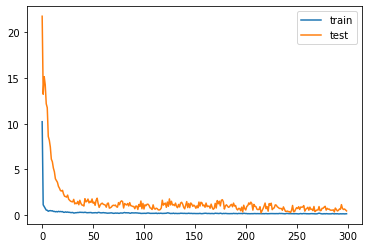

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

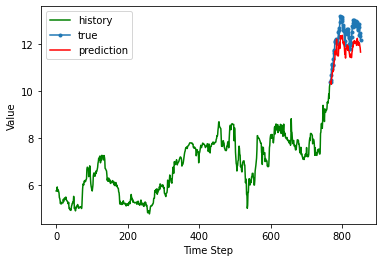

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

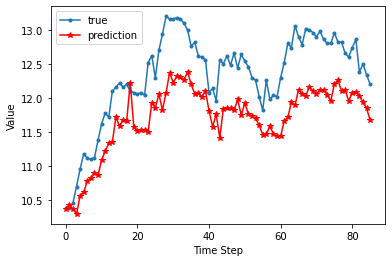

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
mean_absolute_percentage_error(y_test,y_pred)*100

4.998423668199453

In [21]:
mean_squared_error(y_test,y_pred)

0.4509371952636092

In [22]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
Predicted direction accuracy (Up/down):
0.5529411764705883
